#Description: This project uses an LSTM model to predict the closing stock price of the S&P 500 index using the past 1000 day stock price



In [ ]:
!pip install pycodestyle pycodestyle_magic
!pip install flake8
%load_ext pycodestyle_magic

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 41 kB 436 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 61 kB 421 kB/s 
     |████████████████████████████████| 66 kB 2.8 MB/s 
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 5.0.0
    Uninstalling importlib-metadata-5.0.0:
      Successfully uninstalled importlib-metadata-5.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.4.1 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incompatible.
gym 0.25.2 requires importlib-metadata>=4.8.0; python_version < "3.10", but you have importlib-metadata 4.2.0 which is incom

In [ ]:
"""
Installing and importing the required libraries
"""

!pip install --upgrade pandas-datareader
!pip install --upgrade pandas

import math
import pandas_datareader as web
import numpy as np
import pandas as pd
import tensorflow
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

"""
Set the seed used by the psuedorandom number generator for both numpy and
tensorflow to ensure reproducible results
"""

from numpy.random import seed
seed(1)
tensorflow.random.set_seed(2)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 8.0 MB/s 
  Attempting uninstall: pandas-datareader
    Found existing installation: pandas-datareader 0.9.0
    Uninstalling pandas-datareader-0.9.0:
      Successfully uninstalled pandas-datareader-0.9.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# The Data Initialization Class
The class is initialized by saving the user input for the stock ticker. It has the following methods:

*     get_stock_data()
*     plot_closing_data()

Detailed descriptions of each method is outlined in docstring above each function

In [ ]:
class DataInitialization():

    """
    The class is initialized by getting the user input for stock ticker. The
    stock ticker that the user inputs
    should be ones defined by the Yahoo Finance platform
    """
    def __init__(self):
        self.stock_ticker = input("Stock ticker: ")

    """
    Takes the stock ticker as an input and uses it to scrape and return the
    stock data from Yahoo Finance. The timeframe for the stock is from
    2012/01/01 to 2018/12/10
    """
    def get_stock_data(self):
        self.stock_data = web.DataReader(self.stock_ticker,
                                         data_source='yahoo',
                                         start='2012-01-01',
                                         end='2018-12-10')
        return self.stock_data

    """
    Takes the entire dataframe of stock data scraped from Yahoo Finance and
    plots the closing price history
    """
    def plot_closing_price(self):
        plt.figure(figsize=(24, 16))
        plt.title("Close Price History")
        plt.plot(self.stock_data['Close'])
        plt.xlabel('Date', fontsize=20)
        plt.ylabel('Close Price USD ($)', fontsize=20)
        plt.show()

# The Data Processors Class
The initialization of this class requires the stock dataframe from the DataInitialization class. It has the following methods:

*   filter_column()
*   scale_data()
*   define_train_set()
*   define_test_set()

Detailed descriptions of each method is outlined in docstring above each function

In [ ]:
class DataProcessors():

    """
    The class is initialized by getting the stock data in the form of a pandas
    dataframe (i.e. stock_data from the DataInitialization class)
    """

    def __init__(self, df):
        self.df = df

    """
    Takes the entire dataframe of stock data scraped from Yahoo Finance and
    filters the closing price, and returns the Numpy representation of the
    Closing price data
    """

    def filter_column(self):
        data = self.df.filter(['Close'])
        self.dataset = data.values

        return self.dataset

    """
    Takes the Numpy representation of the Closing price data and scales it
    from a range of 0 to 1 for pre-processing purposes. The function returns
    the scaled data
    """
    def scale_data(self):
        scaler = MinMaxScaler(feature_range=(0, 1))
        self.scaled_data = scaler.fit_transform(self.dataset)
        return self.scaled_data

    """
    Takes the scaled data and uses it to create the training data. The data
    looks at the past 1000 trading days, and the x_train is reshaped to fit
    into the LSTM model. The function returns a tuple of x_train and y_train
    """
    def define_train_set(self):
        training_data_len = math.ceil(len(self.dataset) * 0.8)
        train_data = self.scaled_data[0:training_data_len, :]

        self.x_train = []
        self.y_train = []

        for i in range(1000, len(train_data)):
            self.x_train.append(train_data[i - 1000:i, 0])
            self.y_train.append(train_data[i, 0])

        self.x_train = np.array(self.x_train)
        self.y_train = np.array(self.y_train)

        self.x_train = np.reshape(self.x_train,
                                  (self.x_train.shape[0],
                                   self.x_train.shape[1],
                                   1))

        return self.x_train, self.y_train

    """
    Takes the raw and scaled data of the Close column and uses it to create the
    testing dataset. Similar to the define_train_set() function, the data looks
    at the past 1000 trading days, and x_test is reshaped to fit the model. The
    function returns a tuple of x_test and y_test
    """
    def define_test_set(self):
        training_data_len = math.ceil(len(self.dataset) * 0.8)

        test_data = self.scaled_data[training_data_len - 1000:, :]

        x_test = []
        self.y_test = self.dataset[training_data_len:, :]

        for i in range(1000, len(test_data)):
            x_test.append(test_data[i-1000:i, 0])

        x_test = np.array(x_test)
        self.x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

        return self.x_test, self.y_test

# The Model Operators Class
The initialization of this class requires the x_train, y_train, x_test, and the dataset that is created from the DataProcessors class. It has the following methods:

*   build_model()
*   train_model()
*   get_prediction()

Detailed descriptions of each method is outlined in docstring above each function

In [ ]:
class ModelOperators():

    """
    The class is initialized by getting the x_train, y_train, x_test arrays,
    and dataset from the DataProcessors class as parameters. Additionally,
    it asks the user for the epoch value, which will be used in the train_model
    function
    """

    def __init__(self, x_train, y_train, x_test, dataset):
        self.epoch_value = int(input("Epoch value: "))
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.dataset = dataset

    """
    Builds the LSTM model. The model has an input layer and one hidden layer,
    both with 300 nodes, and an output layer.
    """

    def build_model(self):
        model = Sequential()
        model.add(LSTM(300, return_sequences=True,
                       input_shape=(x_train.shape[1], 1)))
        model.add(LSTM(300, return_sequences=False))
        model.add(Dense(1))

        self.model = model

    """
    Trains the model defined in the build_model function using the x_train and
    y_train arrays
    """

    def train_model(self):
        self.model.compile(optimizer='adam', loss='mean_squared_error')
        self.model.fit(self.x_train, self.y_train, batch_size=1,
                       epochs=self.epoch_value)

    """
    Takes the LSTM model and x_test as input and returns an array of prediction
    values. Additionally, it inverses the scaling that was done in the
    scale_data() function and returns an array of the raw prediction values
    as output
    """

    def get_prediction(self):
        self.predictions = self.model.predict(self.x_test)
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled_data = scaler.fit_transform(self.dataset)
        self.predictions = scaler.inverse_transform(self.predictions)
        return self.predictions

# The Assessment Metrics Class
The initialization of this class requires predictions from the ModelOperators class, the dataset and y_testfrom the DataProcessors class, and the stock dataframe from the DataInitialization class. It has the following methods:

*       calculate_nrmse()
*   plot_predicted_values()

Detailed descriptions of each method is outlined in docstring above each function

In [ ]:
class AssessmentMetrics():

    """
    The class is initialized by getting the array of raw prediction values
    from the ModelOperators class, the dataset and y_test from the
    DataProcessors class, and df from the DataInitialization class
    """

    def __init__(self, predictions, dataset, y_test, df):
        self.predictions = predictions
        self.dataset = dataset
        self.y_test = y_test
        self.df = df

    """
    The RMSE is calculated from the values in y_test and predictions. This is
    then normalized to allow for comparisons across models that use different
    stocks
    """

    def calculate_nrmse(self):
        rmse = np.sqrt(np.mean(((self.y_test - self.predictions)**2)))
        self.normalized_rmse = rmse/(self.dataset.max() - self.dataset.min())

    """
    Takes the entire dataframe and the array of raw predicted values as input.
    Plots the Predicted vs Actual Prices, along with the data that was used for
    training
    """

    def plot_predicted_values(self):
        training_data_len = math.ceil(len(self.dataset) * 0.8)
        close = self.df.filter(['Close'])

        train = close[:training_data_len]
        valid = close[training_data_len:]
        valid['Predictions'] = self.predictions

        plt.figure(figsize=(16, 8))
        plt.title('Predicted vs Actual Prices')
        plt.xlabel('Date', fontsize=18)
        plt.ylabel('Close Price USD ($)', fontsize=18)
        plt.plot(train['Close'])
        plt.plot(valid[['Close', 'Predictions']])
        plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
        plt.show()

# At this point, all the necessary classes and methods have been defined. Thus, the following chunks of code will outline how to use the classes and methods. Simply compile the code, and input the stock ticker and epoch values when prompted.

## 1. Choosing the stock by inputting the stock ticker and plotting the closing price history

In [ ]:
initial_data = DataInitialization()
df = initial_data.get_stock_data()

Stock ticker: TSLA


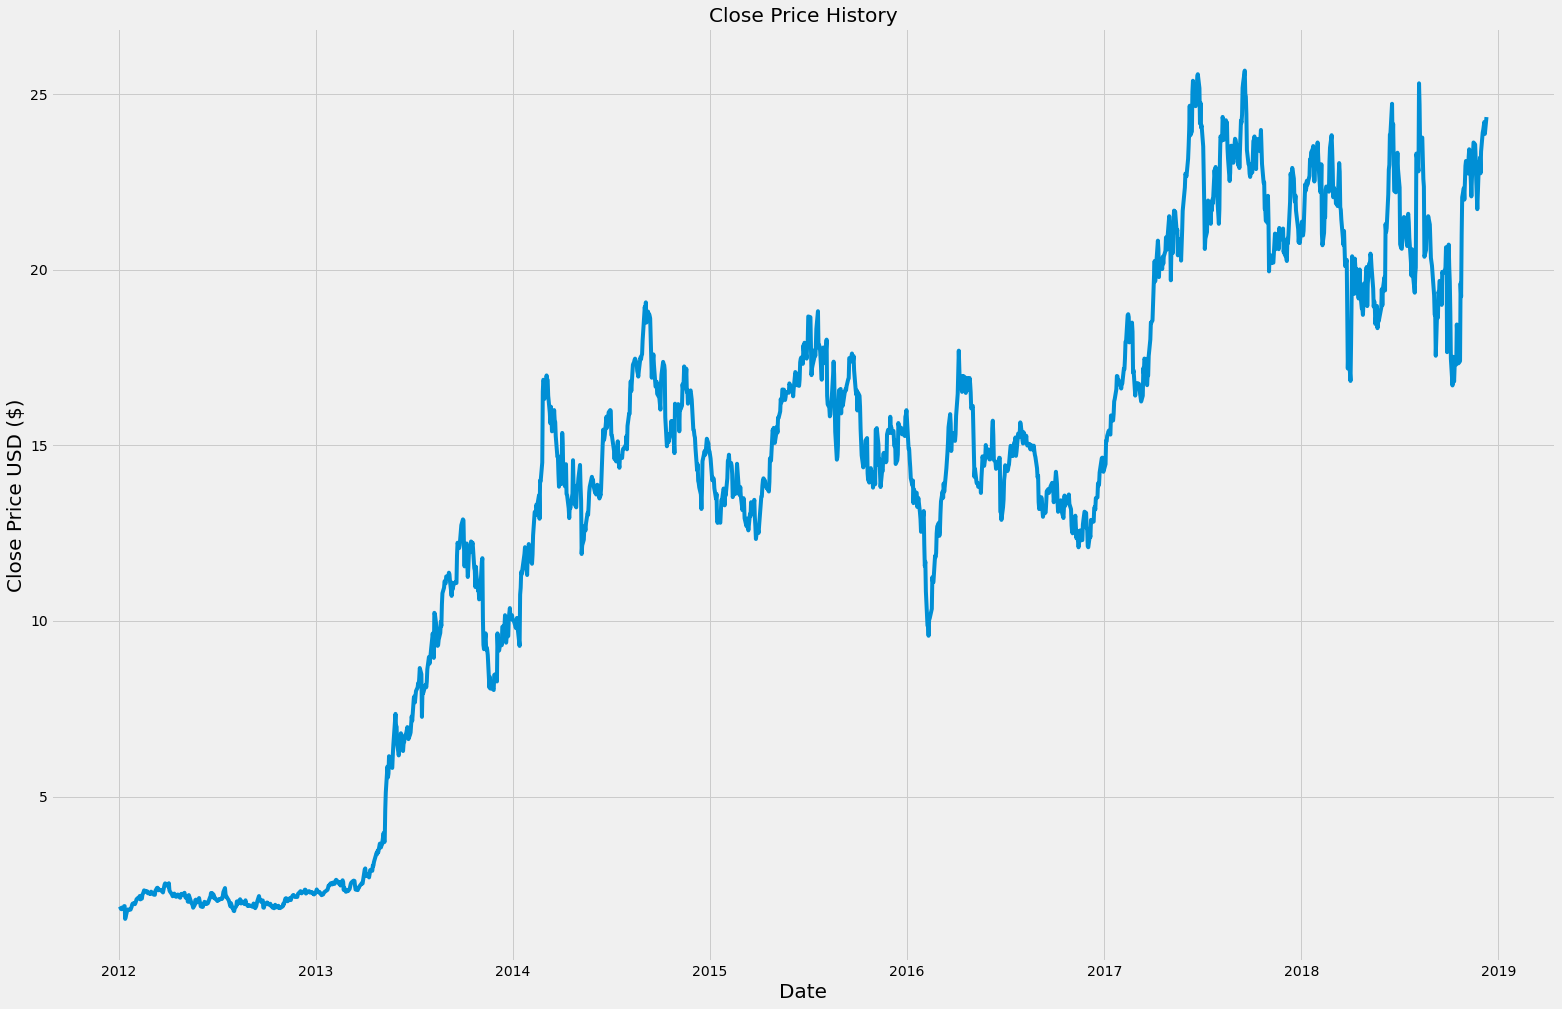

In [ ]:
initial_data.plot_closing_price()

## 2. Pre-processing the stock data by filtering the ['Close'] column, scaling it, and defining the training and testing data sets

In [ ]:
processed_data = DataProcessors(df)
dataset = processed_data.filter_column()
scaled_dataset = processed_data.scale_data()
x_train, y_train = processed_data.define_train_set()
x_test, y_test = processed_data.define_test_set()

##3. Building the model, training it using the training dataset defined above, and getting the predicted values

In [ ]:
lstm_model = ModelOperators(x_train, y_train, x_test, dataset)
lstm_model.build_model()
lstm_model.train_model()
lstm_model.get_prediction()

Epoch value: 5
Epoch 1/5
397/397 [==============================] - 55s 113ms/step - loss: 0.0062
Epoch 2/5
397/397 [==============================] - 50s 125ms/step - loss: 0.0021
Epoch 3/5
397/397 [==============================] - 46s 115ms/step - loss: 0.0017
Epoch 4/5
397/397 [==============================] - 44s 111ms/step - loss: 0.0012
Epoch 5/5
397/397 [==============================] - 45s 114ms/step - loss: 7.8714e-04


array([[21.29163 ],
       [21.725405],
       [21.959448],
       [22.174234],
       [21.983692],
       [21.792732],
       [21.311605],
       [20.853788],
       [20.793789],
       [21.51159 ],
       [22.41814 ],
       [22.933323],
       [23.44572 ],
       [23.650385],
       [23.411407],
       [23.229784],
       [23.30243 ],
       [23.342186],
       [23.375807],
       [23.04656 ],
       [22.647   ],
       [22.110338],
       [21.898386],
       [22.219809],
       [22.546679],
       [22.601154],
       [22.504229],
       [22.465685],
       [22.633764],
       [22.857021],
       [22.978344],
       [22.837278],
       [22.535189],
       [22.512203],
       [22.331818],
       [22.837143],
       [23.24424 ],
       [23.569124],
       [24.086533],
       [24.47009 ],
       [24.802605],
       [24.633375],
       [24.371536],
       [23.947447],
       [23.183968],
       [22.500534],
       [22.156134],
       [21.930017],
       [21.821358],
       [21.86308 ],


##4. Assessing the model through nRMSE values and the Predicted vs Actual plot

In [ ]:
model_assessments = AssessmentMetrics(lstm_model.predictions, dataset,
                                      y_test, df)
model_assessments.calculate_nrmse()
print("nRMSE value:", model_assessments.normalized_rmse)

nRMSE value: 0.04087386481961812


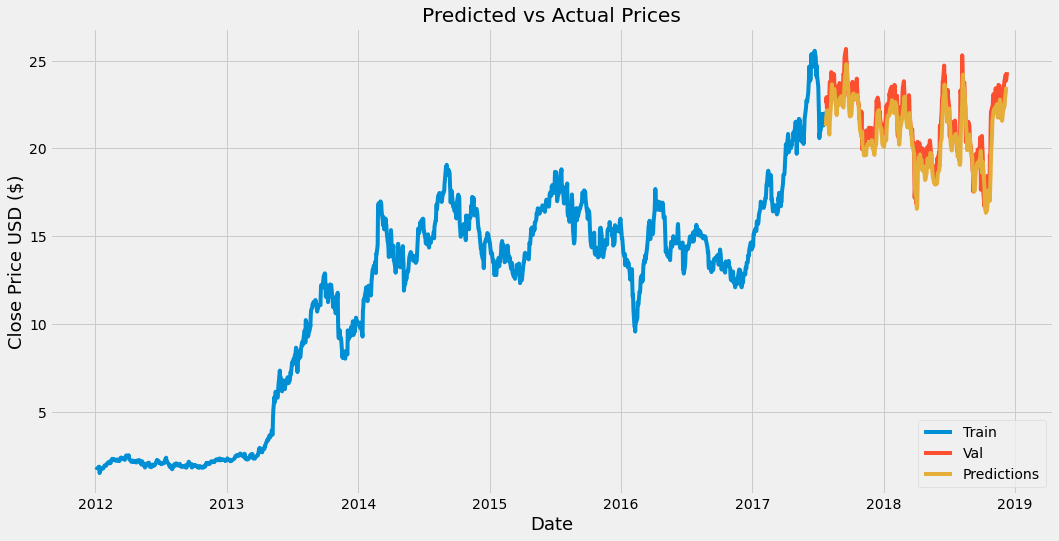

In [ ]:
model_assessments.plot_predicted_values()